In [1]:
import os
import torch
torch.cuda.set_device(0)
from video_dataset import image_data
from models import Attentive_VGG
import numpy as np
import torch.nn.utils as utils
import json
import argparse
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.misc import imread, imresize
from torchvision.transforms import ToPILImage
from PIL import Image

is_cuda = torch.cuda.is_available()
base_path = '/export/livia/Database/AFEW/Faces'

In [2]:
exp = {
    "paper_master":{
    "base_lr": 1e-2, "lrs": [10, 1], "wd": 5e-4, "seeds": [0], "opt": "sgd", "cuda": 5, "shift": False, 
    "eval_fact": 40, "net": "vgg16", "pooling":"softmax", "attention_hop":2, "dropout": 0, "ep": 30,
    "comment" : "with attention",
    "status": "Done 48.8"
    },
    "paper_master_att_1":{
        "base_lr": 1e-2, "lrs": [10, 1], "wd": 5e-4, "seeds": [0], "opt": "sgd", "cuda": 5, "shift": False, 
        "eval_fact": 40, "net": "vgg16", "pooling":"softmax", "attention_hop":2, "dropout": 0, "ep": 30,
        "comment" : "with attention at the end",
        "status": "??"
        },
}
name = "paper_master_att_1"

In [3]:
model = Attentive_VGG(num_classes=7, shift=exp[name]['shift'],
                      weights=os.path.join(base_path, 'models', 'pretrained'), net=exp[name]['net'],
                    pooling=exp[name]['pooling'], attention_hop=exp[name]['attention_hop'],
                    dropout=exp[name]['dropout'])


model.load_state_dict(torch.load(os.path.join(base_path, 'models', 'paper', name + '.pth')))

if is_cuda:
    model.cuda()

model.eval()
_, valid_loader = image_data(path=base_path, num_frames_per_clip=16,
                    bs=3, debug=False, 
                    size=224, num_workers=8, eval_fact=exp[name]['eval_fact'])

idx2class = {k:v for k,v in enumerate(valid_loader.dataset.classes)}

vgg16_att_hop_2_False_softmax


In [4]:
with torch.no_grad():
    for data, target in valid_loader:
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        output, spatial, temporal = model(data)

        if target.item() == output.argmax(dim=-1).item():
            break

data = data.squeeze().cpu()
temporal = temporal.squeeze().cpu().numpy()
spatial_all = spatial.mean(-1)
spatial_all = spatial_all.cpu().numpy()
spatial_all = spatial_all.reshape(spatial_all.shape[0], 7, 7)
spatial = spatial.cpu().numpy()
spatial = spatial.reshape(spatial.shape[0], 7, 7, spatial.shape[-1])
print(target, output.argmax(dim=-1))

tensor([4], device='cuda:0') tensor([4], device='cuda:0')


In [5]:
frames = list(range(0, len(data), 3))
frames = frames[:10]
print(frames, len(frames))

[0, 3, 6, 9, 12, 15, 18, 21, 24, 27] 10


In [6]:
temporal.shape

(83, 7)

In [7]:
temporal[frames].max(1).max(0)

0.011573759

TypeError: only integer scalar arrays can be converted to a scalar index

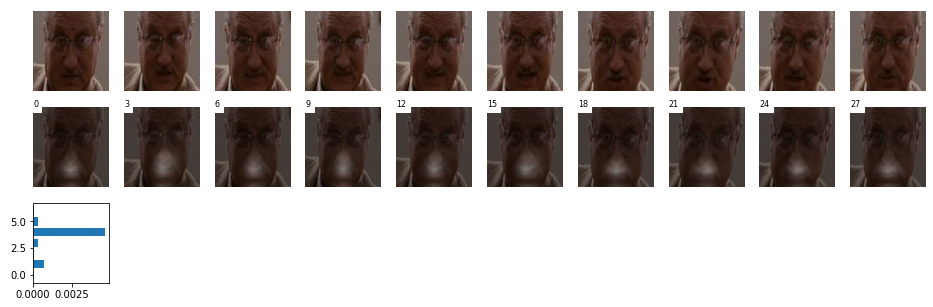

In [59]:
plt.figure(figsize=(16, 5))
salients = temporal.sum(axis=1)
maxx = temporal[frames].max(1).max(0)
cls = target.item().cpu().numpy()[0]


# for idx, t in enumerate(frames, 1):
    
#     plt.subplot(np.ceil(len(frames) / 10.)*4, 10, idx)
    
#     bars = plt.barh(0, salients[t]*10)
#     bars[0].set_facecolor('g')
#     plt.xlim(0, 1)  
#     plt.ylim(0, 1.5) 
#     plt.axis('off')

for idx, t in enumerate(frames, 1):
    image = ToPILImage()(data[t])
    image = image.resize([7 * 48, 7 * 48], Image.LANCZOS)
    
    plt.subplot(np.ceil(len(frames) / 10.)*3, 10, idx + 0*len(frames))    
    plt.imshow(image, aspect='auto')
    
    plt.axis('off')

for idx, t in enumerate(frames, 1):
    
    image = ToPILImage()(data[t])
    image = image.resize([7 * 48, 7 * 48], Image.LANCZOS)
    
    plt.subplot(np.ceil(len(frames) / 10.)*3, 10, idx + 1*len(frames))
    plt.text(0, 1, f'{t}', color='black', backgroundcolor='white', fontsize=8)
    
    plt.imshow(image, aspect='auto')
    current_alpha = spatial_all[t, :,:]
#     current_alpha = spatial[t, :,:, 1]
    alpha = skimage.transform.pyramid_expand(current_alpha, upscale=48, sigma=8)
    plt.imshow(alpha, alpha=0.4, aspect='auto', cmap='gray')
    
    plt.axis('off')
    
# for idx, t in enumerate(frames, 1):

#     plt.subplot(np.ceil(len(frames) / 10.)*4, 10, idx + len(frames)*3)
#     maxx = temporal[frames].max(1).max(0)
#     cls = temporal[t].argmax(axis=-1)
#     x = np.arange(7)
#     bars = plt.bar(x, temporal[t])
#     bars[cls].set_facecolor('r')
#     plt.xticks(x, valid_loader.dataset.classes, rotation='vertical')
#     plt.ylim(0, maxx) 
    
#     ax = plt.gca()
#     ax.get_yaxis().set_visible(False)
#     ax.get_xticklabels()[cls].set_color('red') 

for idx, t in enumerate(frames, 1):

    plt.subplot(np.ceil(len(frames) / 10.)*3, 10, idx + 2*len(frames))
    x = np.arange(7)
    bars = plt.barh(x, temporal[t])
    bars[cls].set_facecolor('r')
    if idx == 1:
        plt.yticks(x, valid_loader.dataset.classes)
        
    plt.xlim(0, maxx) 
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yticklabels()[cls].set_color('red')
    if idx > 1:
        ax.get_yaxis().set_visible(False)

    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

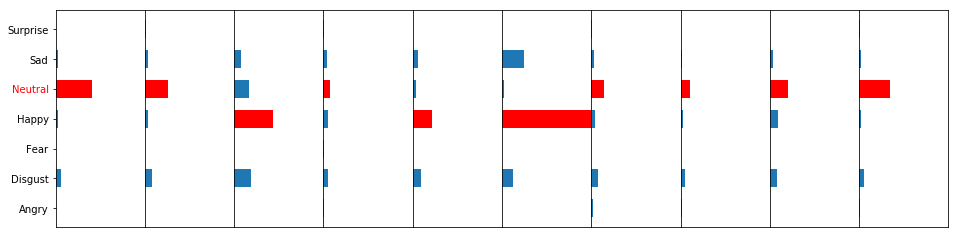

In [56]:
plt.figure(figsize=(16, 4))

for idx, t in enumerate(frames, 1):

    plt.subplot(np.ceil(len(frames) / 10.)*1, 10, idx)
    cls = temporal[t].argmax(axis=-1)
    x = np.arange(7)
    bars = plt.barh(x, temporal[t], 0.6)
    bars[cls].set_facecolor('r')
    if idx == 1:
        plt.yticks(x, valid_loader.dataset.classes)
        
    plt.xlim(0, maxx) 
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yticklabels()[cls].set_color('red')
    if idx > 1:
        ax.get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()